- **By: Andre Siedler**
- Email: andresiedler@hotmail.com

# **Dependecies**

This nootebook requires the following modules:

- import_data.py
- select_pairs.py     
- apply_strategy.py
- performance_evaluation.py

# **Introduction**

This notebook provides a statistical arbitrage pairs trading strategy framework, from downloading the required data to evaluating the results.

Process description:  
    1. Import and process data  
    2. Select pairs through the cointegration approach  
    3. Run a series of backtest simulations of the trading strategy with the selected pairs  
    4. Evaluate results  


# **Importing Libraries**

In [1]:
from datetime import datetime
import pytz
import MetaTrader5 as mt5
import warnings
warnings.filterwarnings('ignore')

from import_data import ImportData
from select_pairs import CointegrationApproach
from apply_strategy import PrepareData, RunStrategy
from performance_evaluation import PBO, SharpeAnalysis, StrategyRisk, VisualizeEquity

# **1. Import and Process Data**

As a first step, all the tickers from the current composition of the market brazilian index Ibovespa are downloaded relying on the yahoo finance library.  
Then, five minute interval closing prices of all the tickers are retrieved from the MetaTrader5 plataform.  

The downloaded data is diveded in two periods:  
- Train set: May/2022, where the pairs are selected according to several criteria  
- Test set: June/2022, where the backtests simulations are conducted

In [2]:
start_train = datetime(2022, 5, 1, tzinfo=pytz.timezone('America/Sao_Paulo'))
end_train = datetime(2022, 6, 1, tzinfo=pytz.timezone('America/Sao_Paulo'))
start_test = datetime(2022, 6, 1, tzinfo=pytz.timezone('America/Sao_Paulo'))
end_test = datetime(2022, 7, 1, tzinfo=pytz.timezone('America/Sao_Paulo'))
interval = mt5.TIMEFRAME_M5

import_data = ImportData(interval, start_train, end_train, start_test, end_test)
data_train, data_test = import_data.get_prices()

Connected to MetaTrader5
Asset not found:  AZUL4
Asset not found:  BRDT3
Asset not found:  BRML3
Asset not found:  BTOW3
Asset not found:  ELET3
Asset not found:  GNDI3
Asset not found:  HGTX3
Asset not found:  IGTA3
Asset not found:  LAME4
Asset not found:  PCAR3
Asset not found:  SANB11
Asset not found:  VIVT4
Asset not found:  VVAR3
Asset not found:  BRDT3
Asset not found:  BTOW3
Asset not found:  GNDI3
Asset not found:  HGTX3
Asset not found:  IGTA3
Asset not found:  LAME4
Asset not found:  VVAR3


A few stocks of the current Ibovespa's composition are not available in the MetaTrader5 plataform, so a total number of 66 stock price series gets downloaded, in addition to the time index for the test period

# **2. Cointegration Approach**

Once the data is available and has been properly processed, a series of statistical procedures is applied on the train set to select pairs of stocks with the purpose of applying a pairs trading strategy:  
1. Stationarity test of each asset from the universe considered    
2. Select assets that show evidence of being integrated of order 1    
3. Group the selected assets by sector    
4. Pairwise cointegration tests (Engle-Granger and Johansen) of all the permutations in the assets' sectors   
5. Select the pairs that reach the desired statistical significance on the cointegration tests     
6. Calculate the hedge ratios of the selected pairs through linear regression   
7. Calculate the spreads of the selected pairs using the hedge ratios as the coefficient parameter    
8. Calculate the Hurst Exponent of each spread    
9. Calculate the half-life of each spread    
10. Calculate the number of zero-crossings of each spread    

Criteria for selecting the pairs:    
- Statistical significance of the cointegration test: 0.10 (p-value smaller than 0.10)  
- Hurst Exponent smaller than 0.5  
- Half-life with minimum value of 5 and maximum value of 50  
- Minimum number of zero crossings: 3  

Finally, the pairs that meet those criteria are selected for the application of the pairs trading strategy on the test set.

In [5]:
cointegration_approach = CointegrationApproach(data_train, data_test)
selected_pairs, unique_assets, df_stats_test = cointegration_approach.select_pairs()

Searching for pairs in sector:  Utilities
Pair found: ('CPFE3', 'ELET6')
Pair found: ('EQTL3', 'ENGI11')
Searching for pairs in sector:  Industrials
Searching for pairs in sector:  Financial Services
Searching for pairs in sector:  Healthcare
Searching for pairs in sector:  Technology
Searching for pairs in sector:  Real Estate
Pair found: ('BRML3', 'MULT3')
Searching for pairs in sector:  Consumer Defensive
Searching for pairs in sector:  Energy
Pair found: ('PETR4', 'PETR3')
Searching for pairs in sector:  Consumer Cyclical
Searching for pairs in sector:  Basic Materials
Total number of sectors analyzed: 10
Found 4 pairs
The pairs contain 8 unique assets


# **3. Apply Strategy**

Once the pairs have been selected, it is time to apply the strategies simulations on the testing period.  
Strategy information:  
- Intraday strategy analyzing market conditions every 5 minute interval.  
- Searches for market opportunities from the start session time, set at 10:30 am (30 minutes after the
  actual market opening), until the end of session time, set at 16:00 (1 hour before the actual market
  closing).  
- From the end session time until the actual close market time all the positions are closed at market value,
  therefore no positions are held overnight (rental costs from short positions are not generated).  
- The strategy algorithm takes a long (short) position on a pair if the spread of the pair deviates from its
  normalized mean (equals zero by construction) more than the long_entry (short_entry) parameter and closes the
  pair's position if the spread of the pair crosses the long_exit (short_exit) parameter.  
- The trading algorithm only takes a position on a pair if no positions are currently opened for that pair.  
- The portfolio positions are set to be equally weighted across pairs (pair position = 1 / total number of
  pairs).  
- Backtests simulations are executed varying the strategy parameters (long entry, short entry, long exit and
  short exit), which aims to create empirical distribution for each statistic of interest, instead of just a
  point estimate.  
- Transactions costs: There are no brokerage fees, so the transactions costs considered are from B3
  (brazilian stock exchange) and slippage. Following (Pontuschka & Perlin, 2015) and (Junior, 2019), the
  total cost per transaction is set at 0,04%.   

In [6]:
prepare_data = PrepareData(df_stats_test, data_test)
traded_assets, trades, prices = prepare_data.prepare_data()

run_strategy = RunStrategy(trades, prices, traded_assets, selected_pairs, cash=100000, commission=0.0004)
equity, returns, ann_sharpes, sharpes, n_trades, trades_pnl = run_strategy.run_strategy()

Sharpe ratio: 9.0014 | Number of trades: 151 | Parameters: Long[-1.5, -0.75] - Short[1.0, 0.25] | Final Portfolio Value: 111,711.05
Sharpe ratio: 7.8546 | Number of trades: 152 | Parameters: Long[-1.5, -0.75] - Short[1.0, 0.5] | Final Portfolio Value: 109,322.79
Sharpe ratio: 7.1252 | Number of trades: 156 | Parameters: Long[-1.5, -0.75] - Short[1.0, 0.75] | Final Portfolio Value: 109,335.68
Sharpe ratio: 7.8735 | Number of trades: 138 | Parameters: Long[-1.5, -0.5] - Short[1.0, 0.25] | Final Portfolio Value: 109,731.39
Sharpe ratio: 7.2575 | Number of trades: 140 | Parameters: Long[-1.5, -0.5] - Short[1.0, 0.5] | Final Portfolio Value: 108,749.77
Sharpe ratio: 6.9410 | Number of trades: 141 | Parameters: Long[-1.5, -0.5] - Short[1.0, 0.75] | Final Portfolio Value: 108,615.14
Sharpe ratio: 8.5558 | Number of trades: 134 | Parameters: Long[-1.5, -0.25] - Short[1.0, 0.25] | Final Portfolio Value: 110,628.05
Sharpe ratio: 7.2098 | Number of trades: 137 | Parameters: Long[-1.5, -0.25] - Sh

# **4. Evaluate Results**

## **4.1 Equity Curve**

The analysis of the strategy performance starts with the visualization of the equity curve of each backtest simulation (grey lines) and the performance of the BOVA11 ETF, whick tracks the Ibovespa index, for the same period.

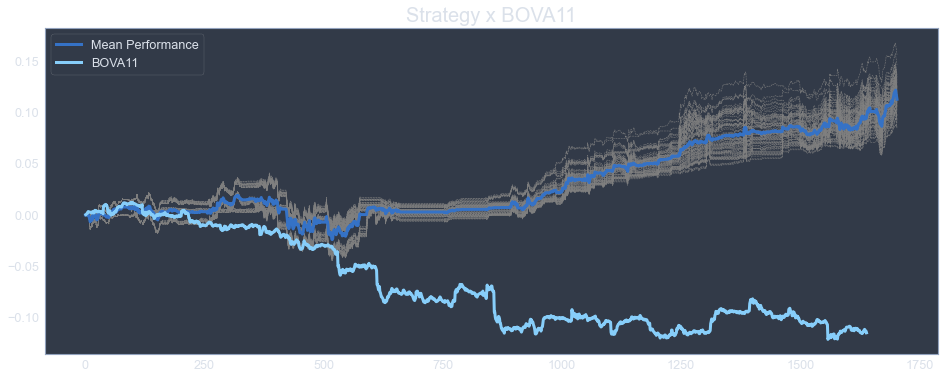

In [7]:
visualize_equity = VisualizeEquity(equity, returns, start_test, end_test, interval='5m')
visualize_equity.equity_returns()

Main takeaways:  
- As expected, the simulations are highly correlated with each other and uncorrelated with the market index;    
- The annualized Sharpe ratios of the backtests are considerably high (above 5.0);    
- Every simulation of the strategy outperforms the market index by a large margin.     

Based solely on the equity curve and the high Sharpe ratios (all individually statistically significant for the standard 5% significance level), this strategy could prematurely be considered a viable investment strategy. However, other fundamental aspects, such as multiplicity of trials and non-normality of returns dustributions should be considered. In the next sections the strategy will be evaluated in a deeper level.

## **4.2 Sharpe Analysis**

Several characteristics of financial assets series produce an inflationarity effect on the estimate of the Sharpe ratio. Therefore, accessing the performance of a strategy requires a measure that takes into account the foolowing aspects:  
- Sample size  
- Skew  
- Kurtosis  
- Total number of trails  
- Variance across trials
    
Accordingly, the deflated Sharpe ratio provides an adjusted estimate. It can be expressed as:

$SR^* = \sqrt{V[\{\widehat{SR}_n\}]}((1-\gamma)Z^{-1}[1-\frac{1}{N}]+\gamma Z^{-1}[1-\frac{1}{N}e^{-1}]$,

where:  

$V[\{\widehat{SR}_n\}]$ is Variance across trials' estimated Sharpe ratios  
$Z[.]$ is the cumulative distribution function of the standard Normal distribution  
$N$ is the estimate of the number of independent trials  
$\gamma$ is the Euler-Mascheroni constant  
$n = 1, 2, ..., n$

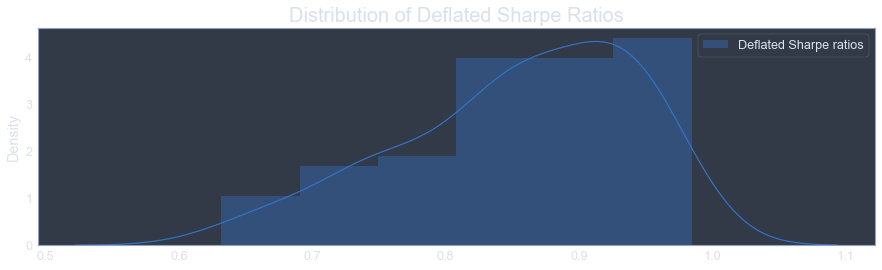

Proportion of deflated Sharpe ratios below 0.05 statistical significance level: 0.14


In [8]:
sharpe_analysis = SharpeAnalysis(trades_pnl, start_test, end_test, ann_sharpes, n_trades)
sharpe_analysis.distribution_dsr()

The distribution of deflated Sharpe ratios shows that, after accounting for the aforementioned infalationary effects, only 14% of the Sharpes are statistically different than zero at a 5% significance level.

## **4.3 Probability of Backtest Overfitting**

To continue accessing the strategy's overall performance, this section will analyze the probability of backtest overfitting (PBO) through Combinatorially Symmetric Cross-Validation (CSCV).  

The CSCV method partitions the returns (or profit and losses) matrix, which contains the backtests trials as columns and the returns at every point in time as rows, across rows into an even number S of submatrices of equal dimensions. Each submatrix is of order $\frac{T}{S}xN$. Then, these submatrices are are taken in groups of size $\frac{S}{2}$ to form $C$ number of combinations:  

$C = \prod_{i=0}^{\frac{S}{2}-1} \frac{S-i}{\frac{S}{2}-i}$

The PBO can be defined as a non-parametric, model-free procedure that aims to quantify the likelihood of backtest overfitting, more specifically, evaluates the conditional probability that a particular strategy underperforms the median out of sample set while still optimal in sample.  

Next, it is presented a brief introduction for estimating the PBO (for a detailed discution of the subject, check chapter 11 of [1], [2] and [3]):  
- Each group of size $\frac{S}{2}$ formed in the CSCV method forms a training set denoted $J$;  
- Each complement of $J$ (formed by all the rows of the performance matrix that are not part of $J$) forms the testing set, denoted $\bar{J}$;  
- The Sharpe ratio is calculated on the train set and on the test set of every combination $C$;    
- The Sharpes of the train set form a vector $R$ of order $N$ (the $n^{th}$ item of $R$ relates to the performance assciated with the $n^{th}$ column of $J$);  
- Find the element $n^*=argmax_n {R_n}$ (the best performance element of the training set);   
- Form a vector $\bar{R}$ from the Sharpe ratios of the test set, in a analogue way of the $R$ vector;    
- Determine the relative rank of the out-of-sample perfoemance associated with the trial chosen in-sample (the relative rank of $\bar{R}_{n^*}$ within $\bar{R}$), denoted by $\bar{w}_c$, where $\bar{w}_c \in (0,1)$;  
- For strategies that do not overfit, $\bar{R}_{n^*}$ should consistently outperform $\bar{R}$ just as ${R}_{n^*}$ outperforms $R$.  
- Calculate the logit $\lambda_c = log(\frac{\bar{w}_c}{1-\bar{w}_c})$. High logits indicate a consistency between in-sample and out-of-sample performance, which can be considered evidence of low level of backtest overfitting;  
- Finally, the distribution of rank logits is computed and the PBO is defined as the probability associated with in-sample optimal strategies that underperform out-of-sample:  
    
$PBO = \int_{-\inf}^0 f(\lambda)\, d\lambda$

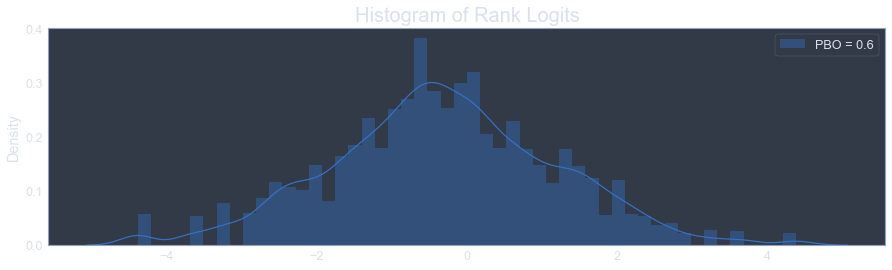

In [9]:
pbo = PBO(returns)
pbo.calculate_pbo()

As shown in the distribution of rank logits, the analyzed trading strategy has a estimated probability of backtest overfitting of 60%, which is considerably high.  

## **4.4 Performance Degradation**

The same pattern of performance decay can be verified in the plots below.  

The first one performs a regression between the the Sharpe ratios in-sample from the best strategy selected and the Sharpe ratios for that same strategy out-of-sample, providing evidence of the degree of performance degradation. The second plot shows the distributions of those in-sample and out-of sample Sharpe ratios.

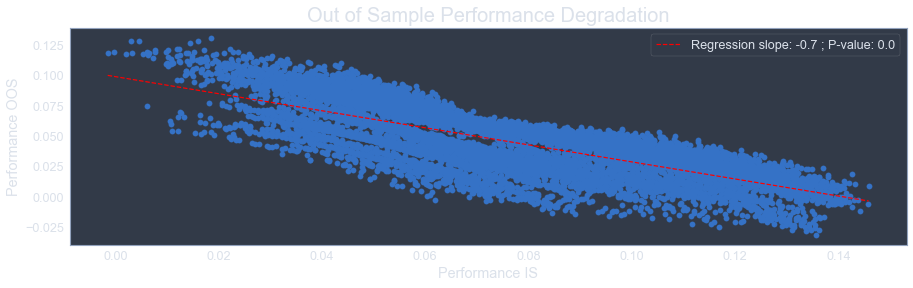

In [10]:
pbo.performance_degradation()

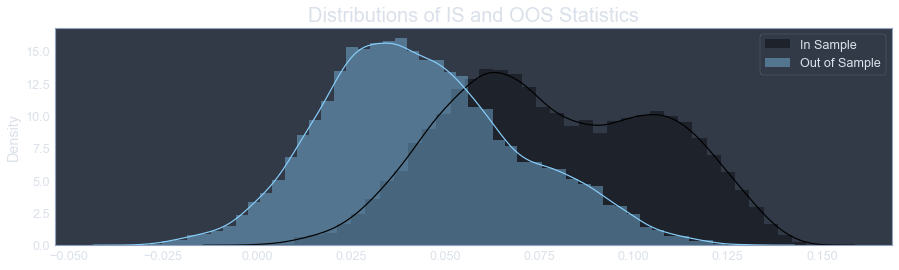

In [11]:
pbo.is_oos_performance()

## **4.5 Strategy Risk**

This section briefly introduces the concept of strategy risk, defined as the probability that the strategy may not generate the target result (a target Sharpe ratio, for this particular implementation). For a detailed discution of the subject, check chapter 15 of [1].

Given the strategy's following parameters:  
$\pi_+ = E[\{\pi_t|\pi_t>0\}_{t=1,...,T}]$: Expected profit per positive trade    
$\pi_- = E[\{\pi_t|\pi_t<=0\}_{t=1,...,T}]$: Expected loss per negative trade  
$p$: Probability of occurring a positive trade    
$1-p$: Probability of occurring a negative trade    
$n$: Expected number of bets (trades) per year  

The expected annualized Sharpe ratio is:

$\theta[p, n, \pi_+, \pi_-] = \frac{nE[X_i]}{\sqrt{nV[X_i]}} = \frac{(\pi_+ - \pi_-)p + \pi_-}{(\pi_+ - \pi_-)\sqrt{p(1-p)}}\sqrt{n}$


Therefore, estimating $\pi_+$, $\pi_-$ and $n$ from the strategy's backtests outcomes, the strategy risk can be computed as $P[p<p_{\theta^*}]$, where $p_{\theta^*}$ is the threshold value of $p$ below which the strategy will not achieve the target Sharpe ratio.  
To compute the quantity $P[p<p_{\theta^*}]$ it is necessary to fit the probability density function $f(p)$ of $p$, which can be approximated fitting a normal distribution as follows:  

$N[\bar{p}, \bar{p}(1 - \bar{p})]$, where $\bar{p} = E(p) = \pi_+ = E[\{\pi_t|\pi_t>0\}_{t=1,...,T}]$  

Finally, setting a target Sharpe ratio and the $p_{\theta^*}$ parameter, the strategy risk can be estimated as:  

$P[p<p_{\theta^*}] = \int_{-inf}^{p_{\theta^*}} f(p) dp$

The plots below illustrate this concept begining with the distribution of the trails' percentage of positive trades and then the distribution of probabilities of failures.

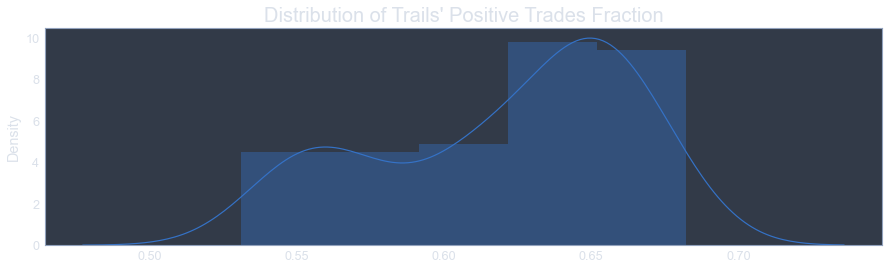

Trials with percentage of positive trades above 0.50: 1.00


In [12]:
strategy_risk = StrategyRisk(n_trades, start_test, end_test, trades_pnl, 1.)
strategy_risk.positive_trades()

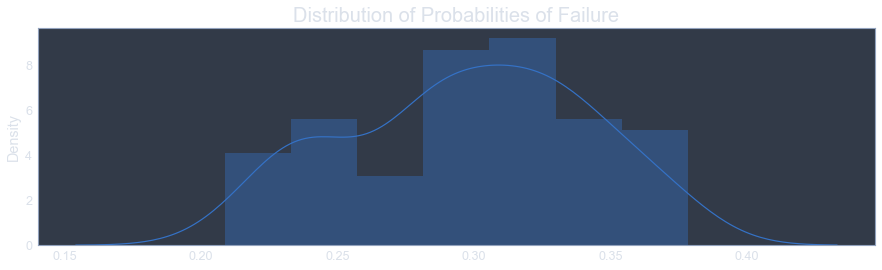

Proportion of trials with probability of failure below 0.05: 0.00


In [13]:
strategy_risk.distribution_prob_f()

Despite the strategy's overall high percentage of positive trades (all trails above 50%), the startegy risk is considerably high, as its distribution has a minimum value around 20% and the peak around 32%. As mentioned in [1], strategies with $P[p<p_{\theta^*}] > 5\%$ are tipically considered too risk.

# **Conclusion**

This notebook describes a statistical arbitrage pairs trading strategy framework, from downloading the required data, selecting pairs of stocks through several statistical criteria, running a series of backtests simulations on a test period, to finally evaluating the results using a few different measures and techniques.

Despite its simplicity, the strategy outperforms the market index benchmark by a large margin and achieves high annualized Sharpe ratios in all the simulations conducted. On the surface, it could be argued that a statistically significant trading strategy has been found. However, when analyzed deeper, making use of measures such as the deflated Sharpe ratio, the probability of backtest overfitting, peformance decay and the strategy risk, the strategy does not provide enough evidence of being a robust investment oportunity.

Finally, the results suggest that this strategy can be further enhanced using more sophisticated techniques in every step of the process, such as feature engeneering, meta-labeling techniques, machine learning algorithms for selecting pairs, optimization of buy and sell thresholds, to cite a few.

# **Next Steps**

- Introduce unsupervised learning algorithms to find clusters of asstes for selecting pairs, like OPTICS or DBSCAN  
- Substitute the pairs' static hedge ratio for a dynamic one, which can be updated based on the pairs' half-lifes
- Implement meta-labeling algorithms for predicting the strategies outcomes

# **References**

[1]. M. L. de Prado, Advances in financial machine learning (John Wiley & Sons, 2018).  

[2]. D. Bailey, J. Borwein, M. López de Prado and J. Zhu, “The probability of backtest overfitting,” working paper, 2013, http://ssrn.com/abstract=2326253.  

[3]. Bailey, D., J. Borwein, M. López de Prado and J. Zhu. “Pseudo-Mathematics and Financial Charlatanism: The Effects of Backtest Overfitting on Out-Of-Sample Performance.” Notices of the American Mathematical Society, Vol. 61, No. 5 (2014), pp. 458-471. Available at http://ssrn.com/abstract=2308659.

[4]. M. L. de Prado. Machine Learning for Asset Managers. Cambridge University Press, 2020.

[5]. Bailey, D. and M. López de Prado. “The Deflated Sharpe Ratio: Correcting for Selection Bias, Backtest Overfitting and Non-Normality.” Journal of Portfolio Management, Vol. 40, No. 5 (2014), pp. 94-107.

[6]. Bailey, David; de Prado, Marcos, ” The Sharpe ratio efficient frontier”, The Journal of Risk, Winter 2012/2013, Vol.15(2), pp. 3-44.

[7]. Lopez de Prado, Marcos. "Deflating the Sharpe Ratio." Available at SSRN 2465675 (2014).

[8].Jansen, Stefan. Machine Learning for Algorithmic Trading: Predictive models to extract signals from market and alternative data for systematic trading strategies with Python. Packt Publishing Ltd, 2020.

[9]. Pairs Trading In Brazil And Short Straddles In The US Market. Available at https://blog.quantinsti.com/algo-trading-epat-projects-12-april-2022/.

[10]. Krauss, C. (2015). Statistical arbitrage pairs trading strategies: Review and outlook. IWQW Discussion Paper Series, University of Erlangen-Nurnberg.

[11]. Sarmento, Simão Moraes, and Nuno Horta. "Enhancing a pairs trading strategy with the application of machine learning." Expert Systems with Applications 158 (2020): 113490.

[12]. Chan, Ernest P. Quantitative trading: how to build your own algorithmic trading business. John Wiley & Sons, 2021.

[13]. Chan, Ernest P. Algorithmic trading: winning strategies and their rationale. Vol. 625. John Wiley & Sons, 2013.

[14]. JUNIOR, F. A. D. L. Expoente DE Hurst e sua Eficácia em Estratégias de Pairs Trading Intradiário no Mercado Brasileiro. Fundação Getulio Vargas, São Paulo, 2019.

[15]. Pontuschka, M., & Perlin, M. (2015). A estratégia de pares no mercado acionário brasileiro: O Impacto da frequência de dados. Revista de Administração Mackenzie, 16(2), 188-213.

[16]. Singh, A., Pachanekar, R. Sharpe Ratio: Calculation, Application, Limitations - Quantinsti blog, available at https://blog.quantinsti.com/sharpe-ratio-applications-algorithmic-trading/

[17]. Pei, H., The Correct Vectorized Backtest Methodology for Pairs Trading, available at https://hudsonthames.org/correct-backtest-methodology-pairs-trading/